# Topics

- Topics : a particular stream of data - simliar to a table in a database
- Topics are split in partitions

# Start Zookeeper & Kafka

```bash
zookeeper-server-start.sh ../config/zookeeper.properties
kafka-server-start.sh ../config/server.properties
```

# Kafka Topics CLI

```bash
kafka-topics.sh --zookeeper 127.0.0.1:2181 --topic first_topic --create --partitions 3 --replication-factor 1
kafka-topics.sh --zookeeper 127.0.0.1:2181 --list
```

# Kafka Console Producer CLI

```bash
kafka-console-producer.sh --broker-list 127.0.0.1:9092 --topic new_topic
kafka-topics.sh --zookeeper 127.0.0.1: --describe new_topic
``` 

# Resetting Offsets

# Retries & max.in.flight.requests.per.connection

- In case of transient failures, developers are expected to handle exceptions, otherwise the data will be lost
- Example of transient failure: NotEnoughReplicasException
- There is a retries setting
    - default to 0
    - you can increase to a high number, ex Integer.MAX_VALUE

- In case of retries, by default there is a change that messages will be sent out of order (if a batch has failed to be sent)
- If you rely on key-based ordering, that can be an issue
- For this, you can set the setting while controls how many produce request can be made in parallel
    - default 5 (then it makes the reordering)
    - set it to 1 if you need to ensure ordering (may impact throughput)

# Idempotent Producer

- you can define a 'idempotent producer' which won't introduce duplicates on network error

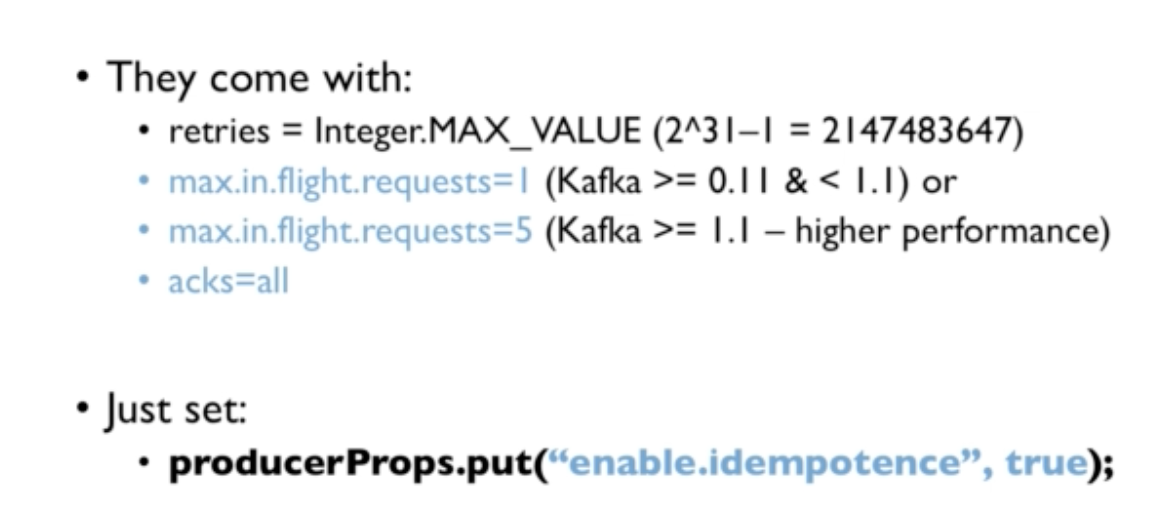

# Safe producer summary & Demo

- kafka < 0.11
    - acks=all
    - min.insync.replicas=2
    - retries=MAX_INT
    - max.in.flight.requests.per.connection=1
- kafka >= 0.11
    - enable.idempotence=true
    - min.insync.replicas=2


# Message Compression

- Producer usually send data that is text-based, for example with JSON data
- In this case, it is important to apply compression to the producer
- Compression is enabled at the Producer level and doesn't require any configuration change in the Brokwers or in the Consumers
- "compression.type" can be 'none' (default), 'gzip', 'lz4', 'snappy'

- https://blog.cloudflare.com/squeezing-the-firehose

- advantages
    - much smaller producer request size
    - faster to transfer data over the network
    - better throughput
    - better disk utilisation in Kafka 
    
- disadvantage
    - producers must commit some CPU cycles to compression
    - consumers must commit some cpu cycles to decompression
    
- Overall
    - consider testing snappy or lz4 for optimal speed

- Recommendations
    - find a compression algorithm that gives you the best performance for your specific data
    - always use compression in production and especially if you have high throughput
    - consider tweaking linger.ms and batch.size to have bigger batches, and therefore more compression and higher throughput

# Linger.ms & batch.size

- By default, Kafka tries to send records as soon as possible
    - It will have up to 5 requests in flight, meaning up to 5 messages individually sent at the same time
    - After this, if more messages have to be sent while others are in flight, Kafka is smart and will start batching them while they wait to send them all at once

- linger.ms : number of milliseconds a producer is willing to wait before sending a batch out (default 0)
    - by introducing some lag (for example linger.ms=5) we increase the changes of messages being sent together in a batch
    - so at the expense of introducing a small delay, we can increase throughput, compression and efficiency of our producer
    - If a batch is full before the end of the linger.ms period, it will be sent to Kafka right away

- batch.size : Maximum number of bytes that will be included in a batch. The default is 16kb
- Increasing a batch size to something like 32KB, or 64KB can help increasing the compression, throughput, and efficiency of requests
- Any message that is bigger than the batch size will not be batched

# Hight throughput Producer

- add snappy message compression

# producer default partitioner and how keys are hashed

- By default, your keys are hashed using the "murmur2" algorithm
- It is most likely preferred to not override the bahavior of the partitioner, but it is possible to do so(partitioner.class)
- targetPartition = Utils.abs(Utils.murmur2(record.key()) % numPartitions;

# max.block.ms & buffer.memory

- If the producer produces faster than the brokwer can take, the records will be buffered in memory
- buffer.memory = 33554432 (32MB) the size of the send buffer
- That buffer will fill up over time and fill back down when the throughput to the brokwer increases

- If that buffer is full (all 32MB), then the .send() method will start to block (won't return right away)
- max.block.ms=60000: the time the .send() will block until throwing an exception. Exceptions are basically thrown when 
    - The producer has filled up its buffer
    - The broker is not accepting any new data
    - 60 seconds has elapsed
    
- If you hit an exception hit that usually means your brokers are down or overloaded as they can't respond to requests